# Digital Image Processing 
## Sudhanva Savyasachi S 21411034 Int.Mtech Geophysical Technology

In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stanford-earthquake-dataset-stead/merge.hdf5
/kaggle/input/stanford-earthquake-dataset-stead/merge.csv


### Loading the Dataset and moulding it into a dataframe having 2 columns Seismogram and Label
- 1 for earthquake
- 0 for Noise

### We have Loaded 20,000 samples into our dataset with 11,000 belonging to earthquake and 9,000 belonging to Noise 
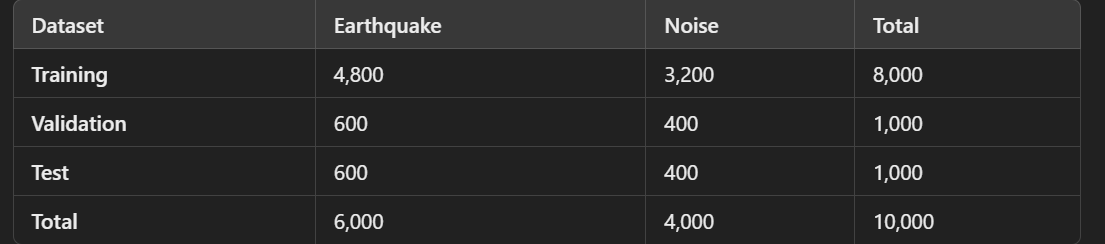

In [51]:
import pandas as pd
import h5py
import numpy as np

# Path to your HDF5 and CSV files
file_name =  '/kaggle/input/stanford-earthquake-dataset-stead/merge.hdf5'
csv_file = '/kaggle/input/stanford-earthquake-dataset-stead/merge.csv'

# Reading the CSV file into a DataFrame
df = pd.read_csv(csv_file)
print(f"Total events in CSV file: {len(df)}")

# Filtering the dataframe to select only earthquake traces
earthquake_df = df[df['trace_category'] == 'earthquake_local']
print(f"Total earthquake events selected: {len(earthquake_df)}")

# Making a list of earthquake trace names
earthquake_list = earthquake_df['trace_name'].tolist()

# For noise data, filtering the dataset for noise traces (assuming 'trace_category' for noise is 'noise')
noise_df = df[df['trace_category'] == 'noise']
print(f"Total noise events selected: {len(noise_df)}")

# Making a list of noise trace names
noise_list = noise_df['trace_name'].tolist()

# Selecting the first 5 earthquake and 5 noise traces
selected_earthquakes = earthquake_list[:11000]
selected_noises = noise_list[:9000]

# Create an empty list to hold the data and labels
data = []
labels = []

# Open the HDF5 file
dtfl = h5py.File(file_name, 'r')

# Retrieve the selected earthquake waveforms and their labels
for trace_name in selected_earthquakes:
    dataset = dtfl.get(f'data/{trace_name}')
    # Retrieve the time signal (for simplicity, using just the first channel)
    signal = np.array(dataset)[:, 0]  # Assuming the first channel (E channel) is used
    data.append(signal)
    labels.append(1)  # Label as 1 for earthquake

# Retrieve the selected noise waveforms and their labels
for trace_name in selected_noises:
    dataset = dtfl.get(f'data/{trace_name}')
    # Retrieve the time signal (again, using the first channel)
    signal = np.array(dataset)[:, 0]  # Assuming the first channel (E channel) is used
    data.append(signal)
    labels.append(0)  # Label as 0 for noise

# Convert the data and labels into a pandas DataFrame
dataset_df = pd.DataFrame({
    'seismogram': data,
    'label': labels
})

# Display the created dataset
print(dataset_df)

# Optionally, save the dataset to a CSV for future use
dataset_df.to_csv('earthquake_noise_dataset.csv', index=False)


/tmp/ipykernel_475/4129885615.py:10: DtypeWarning: Columns (7,11,13,14,24,25,26,30,31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file)


Total events in CSV file: 1265657
Total earthquake events selected: 1030231
Total noise events selected: 235426
                                              seismogram  label
0      [-0.0, -0.008510596, -0.022853209, -0.05171290...      1
1      [-15.846739, -0.74933726, 14.34023, 26.836971,...      1
2      [0.0, 0.0052515115, 0.006549144, 0.009353005, ...      1
3      [-0.0, -0.029477388, -0.07285547, -0.19785853,...      1
4      [0.0, 0.026213303, 0.069299206, 0.17942497, 0....      1
...                                                  ...    ...
19995  [0.0, -0.0029506634, -0.044441253, -0.14154857...      0
19996  [-0.0, -0.026440827, -0.085670695, -0.22961573...      0
19997  [0.0, 0.005072224, 0.0110517675, 0.026247226, ...      0
19998  [-0.0, -0.0043616793, -0.025698723, -0.0870310...      0
19999  [0.0, 0.018277587, 0.078595236, 0.1974342, 0.3...      0

[20000 rows x 2 columns]


### Shuffling the dataset

In [52]:
dataset_df = dataset_df.sample(frac=1, random_state=1).reset_index(drop=True)


In [53]:
dataset_df.sample(6)

,seismogram,label
9188,"[-0.0, -0.08976309, -0.16601877, -0.76072514, ...",1
16103,"[-0.0, -0.005219069, -0.010734687, -0.02272342...",1
14967,"[-0.051552877, 1.4439366, -2.696028, -4.126773...",0
5333,"[-0.0, -0.03521573, -0.09332838, -0.24236237, ...",0
7560,"[-0.0, -0.0056506353, -0.015385652, -0.0386370...",1
17313,"[0.0, 0.0016345411, 0.0043667518, 0.011261144,...",0


### I will now add a new column named freqeuncy which will Convert the following Seismograms into Frequency Domain using Fourier Transform 

In [54]:
def fourier_transform(seismogram, sampling_rate=100):
    n = len(seismogram)
    fft_result = np.fft.fft(seismogram)
    fft_magnitude = np.abs(fft_result[:n // 2])  # Only positive frequencies (3000 points for a 6000 sample input)
    return fft_magnitude

In [55]:
dataset_df['frequency'] = dataset_df['seismogram'].apply(lambda x: fourier_transform(x))

In [56]:
dataset_df.columns

Index(['seismogram', 'label', 'frequency'], dtype='object')

### I will now export it into a new excel file

In [57]:
dataset_df.to_excel("processed_dataset_with_frequency.xlsx", index=False)

### Now I have split the dataset into train and test. 80 percent in traning data and 20 percent in test data

In [58]:
from sklearn.model_selection import train_test_split

# Assume 'label' column has values 1 for earthquake and 0 for noise
train_data, test_data = train_test_split(dataset_df, test_size=0.1,random_state=42)

# Summary of each set
print("Training set:", train_data['label'].value_counts())
print("Test set:", test_data['label'].value_counts())


Training set: label
1    9880
0    8120
Name: count, dtype: int64
Test set: label
1    1120
0     880
Name: count, dtype: int64


## Model

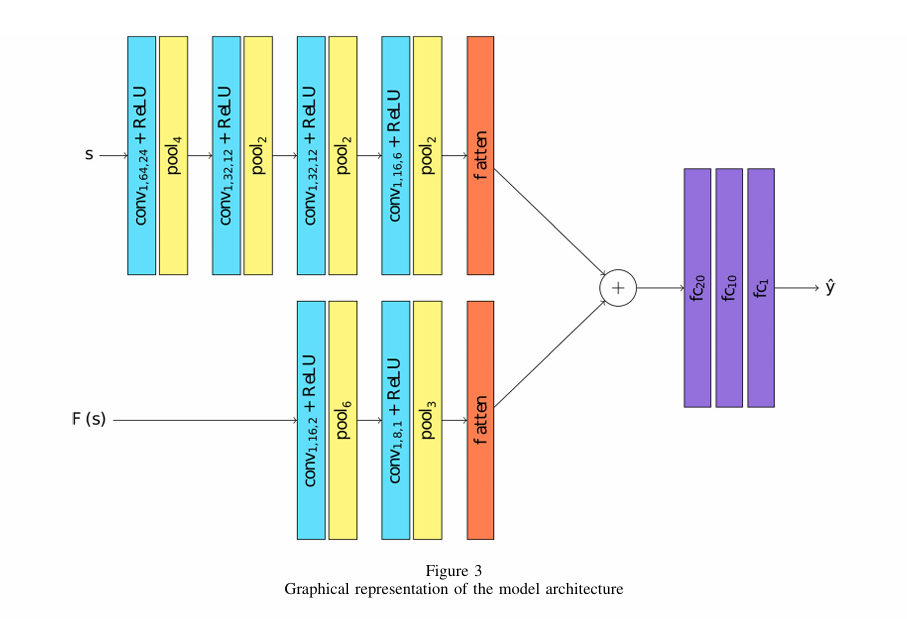

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SeismicModel(nn.Module):
    def __init__(self):
        super(SeismicModel, self).__init__()
        
        # Waveform branch S
        self.waveform_conv1 = nn.Conv1d(1, 64, kernel_size=24)
        self.waveform_conv2 = nn.Conv1d(64, 32, kernel_size=12)
        self.waveform_conv3 = nn.Conv1d(32, 32, kernel_size=12)
        self.waveform_conv4 = nn.Conv1d(32, 16, kernel_size=6)
        
        self.waveform_pool1 = nn.MaxPool1d(kernel_size=4)
        self.waveform_pool2 = nn.MaxPool1d(kernel_size=2)
        self.waveform_pool3 = nn.MaxPool1d(kernel_size=2)
        self.waveform_pool4 = nn.MaxPool1d(kernel_size=2)

        # Frequency branch F(s)
        self.frequency_conv1 = nn.Conv1d(1, 16, kernel_size=2)
        self.frequency_conv2 = nn.Conv1d(16, 8, kernel_size=1)
        
        self.frequency_pool1 = nn.MaxPool1d(kernel_size=6)
        self.frequency_pool2 = nn.MaxPool1d(kernel_size=3)
        
        # Calculate flattened sizes for the waveform and frequency branches to set the input size of fc1
        self.flattened_waveform_size = self.calculate_waveform_output()
        self.flattened_frequency_size = self.calculate_frequency_output()
        
        # Fully connected layers after concatenation
        self.fc1 = nn.Linear(self.flattened_waveform_size + self.flattened_frequency_size, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 1)
        
    def calculate_waveform_output(self):
        # Simulate passing a dummy input through the waveform branch to get output shape
        x = torch.randn(1, 1, 6000)  # Updated to match paper's input size
        x = self.waveform_pool1(F.relu(self.waveform_conv1(x)))
        x = self.waveform_pool2(F.relu(self.waveform_conv2(x)))
        x = self.waveform_pool3(F.relu(self.waveform_conv3(x)))
        x = self.waveform_pool4(F.relu(self.waveform_conv4(x)))
        return torch.prod(torch.tensor(x.shape[1:])).item()  # Excluding batch size
    
    def calculate_frequency_output(self):
        # Simulate passing a dummy input through the frequency branch to get output shape
        x = torch.randn(1, 1, 3000)  # Updated to match paper's input size
        x = self.frequency_pool1(F.relu(self.frequency_conv1(x)))
        x = self.frequency_pool2(F.relu(self.frequency_conv2(x)))
        return torch.prod(torch.tensor(x.shape[1:])).item()  # Excluding batch size
    
    def forward(self, s, f_s):
        # Waveform branch S
        s = F.relu(self.waveform_conv1(s))
        s = self.waveform_pool1(s)
        s = F.relu(self.waveform_conv2(s))
        s = self.waveform_pool2(s)
        s = F.relu(self.waveform_conv3(s))
        s = self.waveform_pool3(s)
        s = F.relu(self.waveform_conv4(s))
        s = self.waveform_pool4(s)
        s = s.view(s.size(0), -1)  # Flatten

        # Frequency branch F(s)
        f_s = F.relu(self.frequency_conv1(f_s))
        f_s = self.frequency_pool1(f_s)
        f_s = F.relu(self.frequency_conv2(f_s))
        f_s = self.frequency_pool2(f_s)
        f_s = f_s.view(f_s.size(0), -1)  # Flatten

        # Concatenate features
        combined = torch.cat((s, f_s), dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(combined))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid for binary classification

        return x

### Model Training

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score

#### We have initalized our weights using Glorot Normal Initialization .We have Adam optmizer with learning rate 0.001 and Binary Cross Entropy loss function

In [96]:
model = SeismicModel()

# Step 1: Initialize weights with Glorot Normal (Xavier Normal) Initialization
def init_weights(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

model.apply(init_weights)

# Step 2: Adam optimizer and binary cross-entropy loss function
optimizer = optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.BCEWithLogitsLoss()  # For binary classification

# Step 3: Early Stopping Parameters
patience = 2
best_val_loss = float('inf')
early_stop_counter = 0
num_epochs = 20

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import numpy as np

### We will Use Standard Scaler to scale both the time domain and freq domain components and then Use pytorch's dataloaders with batch size of 32. We have applied the scaling across each indivisual array

In [98]:
import numpy as np
import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader

# Initialize scalers
waveform_scaler = StandardScaler()
frequency_scaler = StandardScaler()

# Normalize the seismic (waveform) data
train_waveform_scaled = waveform_scaler.fit_transform(np.stack(train_data['seismogram'].to_numpy()))
test_waveform_scaled = waveform_scaler.transform(np.stack(test_data['seismogram'].to_numpy()))

# Normalize the frequency data
train_frequency_scaled = frequency_scaler.fit_transform(np.stack(train_data['frequency'].to_numpy()))
test_frequency_scaled = frequency_scaler.transform(np.stack(test_data['frequency'].to_numpy()))

# Convert normalized data to tensors
train_waveform = torch.tensor(train_waveform_scaled, dtype=torch.float32).unsqueeze(1)
train_frequency = torch.tensor(train_frequency_scaled, dtype=torch.float32).unsqueeze(1)
train_labels = torch.tensor(train_data['label'].to_numpy(), dtype=torch.float32).unsqueeze(1)

test_waveform = torch.tensor(test_waveform_scaled, dtype=torch.float32).unsqueeze(1)
test_frequency = torch.tensor(test_frequency_scaled, dtype=torch.float32).unsqueeze(1)
test_labels = torch.tensor(test_data['label'].to_numpy(), dtype=torch.float32).unsqueeze(1)

# Test DataLoader
test_dataset = TensorDataset(test_waveform, test_frequency, test_labels)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


### In the Below cell we have trained the model using 4-fold cross validation. Due to Limited computation I have Re-trained the model on the complete dataset . I have Used the model 3 which provides the best results on false positive and false negative rate.

In [99]:
# Set up 4-Fold Cross Validation
kfold = KFold(n_splits=4, shuffle=True, random_state=42)
# Track average accuracy and rates over folds
total_train_accuracy = 0
total_val_accuracy = 0
total_train_fpr = 0
total_train_fnr = 0
total_val_fpr = 0
total_val_fnr = 0

# Loop over each fold
for fold, (train_idx, val_idx) in enumerate(kfold.split(train_waveform)):
    print(f'Fold {fold + 1}/4')
    
    # Split data into training and validation sets for this fold
    fold_train_waveform, fold_val_waveform = train_waveform[train_idx], train_waveform[val_idx]
    fold_train_frequency, fold_val_frequency = train_frequency[train_idx], train_frequency[val_idx]
    fold_train_labels, fold_val_labels = train_labels[train_idx], train_labels[val_idx]
    
    # Create DataLoaders for the current fold
    fold_train_dataset = TensorDataset(fold_train_waveform, fold_train_frequency, fold_train_labels)
    fold_train_loader = DataLoader(fold_train_dataset, batch_size=32, shuffle=True)
    
    fold_val_dataset = TensorDataset(fold_val_waveform, fold_val_frequency, fold_val_labels)
    fold_val_loader = DataLoader(fold_val_dataset, batch_size=32, shuffle=False)
    
    # Reset model weights for each fold
    model.apply(init_weights)
    
    # Early stopping variables for each fold
    best_val_accuracy = 0
    early_stop_counter = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_preds = []
        train_true_labels = []
        
        # Training loop
        for wave, freq, label in fold_train_loader:
            optimizer.zero_grad()
            output = model(wave, freq)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            train_preds.extend((output > 0.5).int().view(-1).cpu().numpy())
            train_true_labels.extend(label.int().view(-1).cpu().numpy())
        
        # Calculate training accuracy, FPR, FNR
        train_accuracy = accuracy_score(train_true_labels, train_preds)
        tn, fp, fn, tp = confusion_matrix(train_true_labels, train_preds).ravel()
        train_fpr = fp / (fp + tn)
        train_fnr = fn / (fn + tp)
        
        # Validation loop
        model.eval()
        val_preds = []
        val_true_labels = []
        with torch.no_grad():
            for wave, freq, label in fold_val_loader:
                output = model(wave, freq)
                val_preds.extend((output > 0.5).int().view(-1).cpu().numpy())
                val_true_labels.extend(label.int().view(-1).cpu().numpy())
        
        # Calculate validation accuracy, FPR, FNR
        val_accuracy = accuracy_score(val_true_labels, val_preds)
        tn, fp, fn, tp = confusion_matrix(val_true_labels, val_preds).ravel()
        val_fpr = fp / (fp + tn)
        val_fnr = fn / (fn + tp)
        
        print(f"Epoch {epoch+1}, Train Acc: {train_accuracy:.4f}, Train FPR: {train_fpr:.4f}, Train FNR: {train_fnr:.4f}, Val Acc: {val_accuracy:.4f}, Val FPR: {val_fpr:.4f}, Val FNR: {val_fnr:.4f}")
        
        # Early Stopping based on validation accuracy
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            early_stop_counter = 0
            torch.save(model.state_dict(), f'best_model_fold_{fold+1}.pth')  # Save the best model for this fold
        else:
            early_stop_counter += 1
            if early_stop_counter >= patience:
                print("Early stopping triggered")
                break
    
    # Load the best model for the current fold and accumulate accuracies and rates
    model.load_state_dict(torch.load(f'best_model_fold_{fold+1}.pth'))
    total_train_accuracy += train_accuracy
    total_val_accuracy += val_accuracy
    total_train_fpr += train_fpr
    total_train_fnr += train_fnr
    total_val_fpr += val_fpr
    total_val_fnr += val_fnr



Fold 1/4
Epoch 1, Train Acc: 0.8284, Train FPR: 0.1358, Train FNR: 0.2011, Val Acc: 0.8660, Val FPR: 0.0060, Val FNR: 0.2377
Epoch 2, Train Acc: 0.8741, Train FPR: 0.0066, Train FNR: 0.2244, Val Acc: 0.8636, Val FPR: 0.0055, Val FNR: 0.2426
Epoch 3, Train Acc: 0.8883, Train FPR: 0.0057, Train FNR: 0.1992, Val Acc: 0.9000, Val FPR: 0.0109, Val FNR: 0.1722
Epoch 4, Train Acc: 0.8980, Train FPR: 0.0054, Train FNR: 0.1818, Val Acc: 0.9033, Val FPR: 0.0050, Val FNR: 0.1710
Epoch 5, Train Acc: 0.8961, Train FPR: 0.0056, Train FNR: 0.1852, Val Acc: 0.8916, Val FPR: 0.0055, Val FNR: 0.1919
Epoch 6, Train Acc: 0.9056, Train FPR: 0.0074, Train FNR: 0.1664, Val Acc: 0.8991, Val FPR: 0.0060, Val FNR: 0.1778
Early stopping triggered
Fold 2/4


/tmp/ipykernel_475/2929814350.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_fold_{fold+1}.pth'))


Epoch 1, Train Acc: 0.8236, Train FPR: 0.0805, Train FNR: 0.2560, Val Acc: 0.8629, Val FPR: 0.0045, Val FNR: 0.2431
Epoch 2, Train Acc: 0.8714, Train FPR: 0.0056, Train FNR: 0.2307, Val Acc: 0.8844, Val FPR: 0.0115, Val FNR: 0.1987
Epoch 3, Train Acc: 0.8853, Train FPR: 0.0054, Train FNR: 0.2053, Val Acc: 0.8944, Val FPR: 0.0275, Val FNR: 0.1679
Epoch 4, Train Acc: 0.8912, Train FPR: 0.0077, Train FNR: 0.1927, Val Acc: 0.8764, Val FPR: 0.0035, Val FNR: 0.2195
Epoch 5, Train Acc: 0.8965, Train FPR: 0.0090, Train FNR: 0.1819, Val Acc: 0.9096, Val FPR: 0.0030, Val FNR: 0.1603
Epoch 6, Train Acc: 0.9096, Train FPR: 0.0065, Train FNR: 0.1599, Val Acc: 0.9247, Val FPR: 0.0130, Val FNR: 0.1251
Epoch 7, Train Acc: 0.8988, Train FPR: 0.0054, Train FNR: 0.1806, Val Acc: 0.9000, Val FPR: 0.0035, Val FNR: 0.1771
Epoch 8, Train Acc: 0.9130, Train FPR: 0.0059, Train FNR: 0.1542, Val Acc: 0.9158, Val FPR: 0.0075, Val FNR: 0.1455
Early stopping triggered
Fold 3/4


/tmp/ipykernel_475/2929814350.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_fold_{fold+1}.pth'))


Epoch 1, Train Acc: 0.7929, Train FPR: 0.0143, Train FNR: 0.3658, Val Acc: 0.8680, Val FPR: 0.0064, Val FNR: 0.2347
Epoch 2, Train Acc: 0.8740, Train FPR: 0.0075, Train FNR: 0.2235, Val Acc: 0.8844, Val FPR: 0.0059, Val FNR: 0.2053
Epoch 3, Train Acc: 0.8865, Train FPR: 0.0059, Train FNR: 0.2020, Val Acc: 0.8989, Val FPR: 0.0040, Val FNR: 0.1806
Epoch 4, Train Acc: 0.8946, Train FPR: 0.0067, Train FNR: 0.1866, Val Acc: 0.8913, Val FPR: 0.0109, Val FNR: 0.1887
Epoch 5, Train Acc: 0.8989, Train FPR: 0.0112, Train FNR: 0.1752, Val Acc: 0.9033, Val FPR: 0.0035, Val FNR: 0.1729
Epoch 6, Train Acc: 0.9032, Train FPR: 0.0056, Train FNR: 0.1719, Val Acc: 0.9038, Val FPR: 0.0020, Val FNR: 0.1733
Epoch 7, Train Acc: 0.9074, Train FPR: 0.0048, Train FNR: 0.1649, Val Acc: 0.9020, Val FPR: 0.0030, Val FNR: 0.1758
Epoch 8, Train Acc: 0.9090, Train FPR: 0.0082, Train FNR: 0.1592, Val Acc: 0.9098, Val FPR: 0.0059, Val FNR: 0.1592
Epoch 9, Train Acc: 0.9072, Train FPR: 0.0087, Train FNR: 0.1621, Val Ac

/tmp/ipykernel_475/2929814350.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_fold_{fold+1}.pth'))


Epoch 1, Train Acc: 0.8394, Train FPR: 0.0326, Train FNR: 0.2641, Val Acc: 0.8631, Val FPR: 0.0014, Val FNR: 0.2535
Epoch 2, Train Acc: 0.8827, Train FPR: 0.0056, Train FNR: 0.2077, Val Acc: 0.8809, Val FPR: 0.0019, Val FNR: 0.2200
Epoch 3, Train Acc: 0.8943, Train FPR: 0.0083, Train FNR: 0.1845, Val Acc: 0.8918, Val FPR: 0.0144, Val FNR: 0.1890
Epoch 4, Train Acc: 0.8916, Train FPR: 0.0065, Train FNR: 0.1908, Val Acc: 0.8993, Val FPR: 0.0058, Val FNR: 0.1824
Epoch 5, Train Acc: 0.9025, Train FPR: 0.0075, Train FNR: 0.1703, Val Acc: 0.8942, Val FPR: 0.0014, Val FNR: 0.1956
Epoch 6, Train Acc: 0.9096, Train FPR: 0.0103, Train FNR: 0.1553, Val Acc: 0.8967, Val FPR: 0.0106, Val FNR: 0.1832
Early stopping triggered


/tmp/ipykernel_475/2929814350.py:85: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_fold_{fold+1}.pth'))


In [107]:
model.load_state_dict(torch.load(f'best_model_fold_{3}.pth'))

/tmp/ipykernel_475/3614804871.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'best_model_fold_{3}.pth'))


<All keys matched successfully>

### This is the average of all metrics we calculated over all folds.

In [108]:
# Average metrics over all folds
average_train_accuracy = total_train_accuracy / 4
average_val_accuracy = total_val_accuracy / 4
average_train_fpr = total_train_fpr / 4
average_train_fnr = total_train_fnr / 4
average_val_fpr = total_val_fpr / 4
average_val_fnr = total_val_fnr / 4

print(f"\nAverage Train Accuracy: {average_train_accuracy:.4f}, Average Train FPR: {average_train_fpr:.4f}, Average Train FNR: {average_train_fnr:.4f}")
print(f"Average Val Accuracy: {average_val_accuracy:.4f}, Average Val FPR: {average_val_fpr:.4f}, Average Val FNR: {average_val_fnr:.4f}")




Average Train Accuracy: 0.9127, Average Train FPR: 0.0086, Average Train FNR: 0.1520
Average Val Accuracy: 0.9104, Average Val FPR: 0.0076, Average Val FNR: 0.1570


### We have now Loaded the 3rd Model and then Tested it on the TTest Set

In [109]:
# Test set evaluation using the final fold's best model
test_preds = []
test_true_labels = []
model.eval()
with torch.no_grad():
    for wave, freq, label in test_loader:
        output = model(wave, freq)
        test_preds.extend((output > 0.5).int().view(-1).cpu().numpy())
        test_true_labels.extend(label.int().view(-1).cpu().numpy())

# Test accuracy, FPR, FNR
test_accuracy = accuracy_score(test_true_labels, test_preds)
tn, fp, fn, tp = confusion_matrix(test_true_labels, test_preds).ravel()
test_fpr = fp / (fp + tn)
test_fnr = fn / (fn + tp)

print(f"\nTest Accuracy: {test_accuracy:.4f}, Test FPR: {test_fpr:.4f}, Test FNR: {test_fnr:.4f}")



Test Accuracy: 0.9435, Test FPR: 0.0080, Test FNR: 0.0946


# Summary

- ### The Dataset consist of 11000 earthquake data and 9000 noise data totalling to 20,000 datapoints
- ### The dataset was shuffled and then split into train and test dataset
- ### The model was implemented in pytorch as mentioned in the paper
- ### Then we trained the model using 4-fold cross validation and achieved a accuracy of 94 percent on test set using model 3